# Setup

In [15]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [16]:
%matplotlib inline 

In [3]:
import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

Global seed set to 40


In [4]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


In [5]:
from case_studies.sdss_galaxies.plots.autoencoder import scatter_bin_plot, set_rc_params

In [6]:
set_rc_params()

# Get Config

In [ ]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])
    

# Run

In [ ]:
from bliss.datasets.galsim_galaxies import SingleGalsimGalaxies

In [ ]:
prior = instantiate(cfg.models.prior)

In [ ]:
tile_cat = prior.sample_prior(1, 1, 1, 1)

In [ ]:
tile_cat

In [ ]:
dl = ds.val_dataloader()
for x in dl:
    print(x['images'].shape)

In [ ]:
for x in dl:
    print(x['images'].shape)

In [ ]:
# Load data

# load sdss data
sdss_dir = '/home/imendoza/bliss/data/sdss/'
pixel_scale = 0.393
coadd_file = "/home/imendoza/bliss/data/coadd_catalog_94_1_12.fits"
frame = SDSSFrame(sdss_dir, pixel_scale, coadd_file)

# Encoder blend images

In [5]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../../config"):
    cfg = compose("config", overrides=[])
    
    
enc, dec = load_models(cfg, device)
bp = enc.border_padding
torch.cuda.empty_cache()

In [6]:
enc.n_rows_per_batch = 10
enc.n_images_per_batch = 15

In [7]:
blend_images = torch.load('../../models/simulated_blended_galaxies.pt')
blend_images['images'].shape

torch.Size([10240, 1, 81, 81])

In [8]:
n_images, c, slen, _ = blend_images['images'].shape
background = blend_images['background']
background = background.unsqueeze(0)
background = background.expand(n_images, 1, slen, slen)

In [9]:
tile_map = enc.variational_mode(blend_images['images'], background)

Encoding ptiles: 683it [00:41, 16.26it/s]


In [22]:
full = tile_map.cpu().to_full_params()

In [11]:
print(full.plocs.shape)
print(full.n_sources.max().item())

torch.Size([10240, 7, 2])
7


5 4


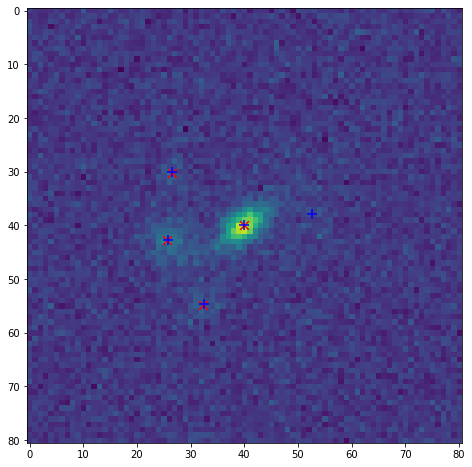

In [54]:
ii = 50
plt.figure(figsize=(8, 8))
plt.imshow(blend_images['images'][ii].cpu().numpy().reshape(slen, slen))
plocs = full.plocs[ii, :full.n_sources[ii].item()].cpu().numpy()
plt.scatter(plocs[:, 1] - 0.5 + enc.border_padding, plocs[:, 0] - 0.5 + enc.border_padding, marker='x', 
            color='r', s=75)
true_plocs = blend_images['plocs'][ii].cpu().numpy()
plt.scatter(true_plocs[:, 1] - 0.5, true_plocs[:, 0] - 0.5, marker='+', 
            color='b', s=100)
print(blend_images['n_sources'][ii].item(), full.n_sources[ii].item())

In [56]:
n_batches = len(full.n_sources)
true_plocs = blend_images['plocs']
est_plocs = full.plocs

In [57]:
est_plocs.shape

torch.Size([10240, 7, 2])

In [60]:
true_plocs.shape

torch.Size([10240, 5, 2])

In [63]:
from bliss.reporting import match_by_locs
for ii in [50]:

    tindx, eindx, dkeep, _ = match_by_locs(true_plocs[ii], est_plocs[ii] + enc.border_padding)
    print(tindx, eindx, dkeep)
    print(true_plocs[ii], est_plocs[ii]  + enc.border_padding)
    print(len(tindx[dkeep]))
    print(true_plocs[ii][tindx][dkeep])
    print(est_plocs[ii][eindx][dkeep] + enc.border_padding)

[0 1 2 3 4] [1 0 4 2 3] tensor([ True,  True, False,  True,  True])
tensor([[40.5000, 40.5000],
        [43.3159, 26.3602],
        [38.3542, 53.1408],
        [55.1063, 32.9522],
        [30.5210, 26.9969]]) tensor([[43.1790, 26.1871],
        [40.5246, 40.3754],
        [55.2508, 32.8165],
        [30.8029, 27.0162],
        [24.0000, 24.0000],
        [24.0000, 24.0000],
        [24.0000, 24.0000]])
4
tensor([[40.5000, 40.5000],
        [43.3159, 26.3602],
        [55.1063, 32.9522],
        [30.5210, 26.9969]])
tensor([[40.5246, 40.3754],
        [43.1790, 26.1871],
        [55.2508, 32.8165],
        [30.8029, 27.0162]])


In [64]:
d = torch.load('../../output/sdss_figures_cache/blendsim_cache.pt')

In [75]:
d['est_ellips'].shape

torch.Size([15084, 2])

(array([6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.320e+02, 9.920e+03, 4.979e+03, 4.500e+01]),
 array([-10.        ,  -8.734262  ,  -7.4685254 ,  -6.2027884 ,
         -4.937051  ,  -3.6713135 ,  -2.4055762 ,  -1.1398389 ,
          0.12589836,   1.3916357 ,   2.657373  ], dtype=float32),
 <BarContainer object of 10 artists>)

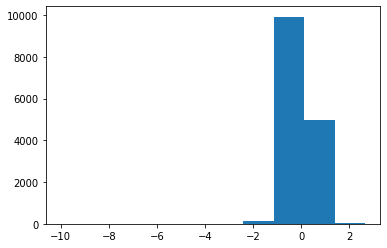

In [83]:
plt.hist(d['true_ellips'][:, 0].numpy(), range)

(array([11622.,  1476.,   639.,   393.,   286.,   242.,   180.,   114.,
           90.,    42.]),
 array([8.2690531e-01, 9.2650658e+01, 1.8447440e+02, 2.7629816e+02,
        3.6812189e+02, 4.5994565e+02, 5.5176941e+02, 6.4359314e+02,
        7.3541687e+02, 8.2724066e+02, 9.1906439e+02], dtype=float32),
 <BarContainer object of 10 artists>)

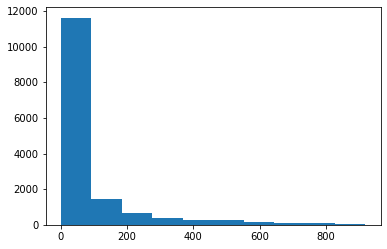

In [82]:
plt.hist(d['snr'].numpy())

Text(0.5, 0, '$a$')

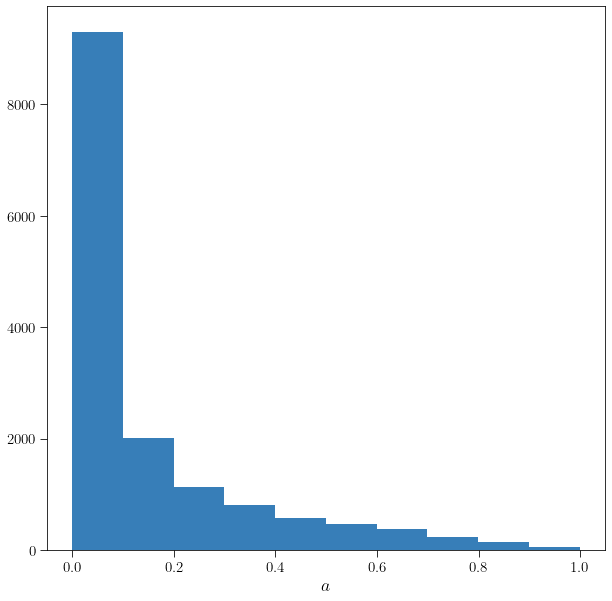

In [87]:
plt.hist(d['blendedness'].numpy())
plt.xlabel(r"$a$")

In [95]:
sum(np.log10(d['snr'].numpy())<0.4)

63

# Dataset of blends

In [11]:
from bliss.catalog import TileCatalog
blend_data = torch.load('../../models/simulated_blended_galaxies.pt')
images = blend_data.pop("images")
background = blend_data.pop("background")
n_batches, _, slen, _ = images.shape
assert background.shape == (1, slen, slen)

# prepare background
background = background.unsqueeze(0)
background = background.expand(n_batches, 1, slen, slen)

# first create FullCatalog from simulated data
tile_cat = TileCatalog(4, blend_data).cpu()
full_truth = tile_cat.to_full_params()

(array([  58.,  763., 6041., 7687., 5245., 3521., 2550., 1730., 1149.,
         677.]),
 array([-0.56605726, -0.21358573,  0.13888578,  0.4913573 ,  0.84382886,
         1.1963004 ,  1.5487719 ,  1.9012434 ,  2.253715  ,  2.6061864 ,
         2.958658  ], dtype=float32),
 <BarContainer object of 10 artists>)

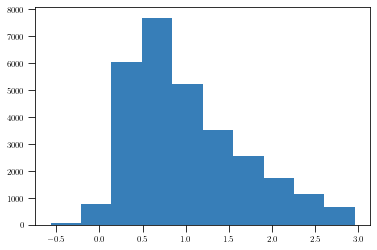

In [21]:
snr = full_truth['snr'].numpy().reshape(-1)
snr = snr[snr!=0]
plt.hist(np.log10(snr))


(array([5621., 2667., 2200., 1821., 1793., 1709., 1888., 2078., 2825.,
        4806.]),
 array([1.4868563e-05, 9.9992074e-02, 1.9996928e-01, 2.9994649e-01,
        3.9992368e-01, 4.9990088e-01, 5.9987807e-01, 6.9985533e-01,
        7.9983252e-01, 8.9980972e-01, 9.9978691e-01], dtype=float32),
 <BarContainer object of 10 artists>)

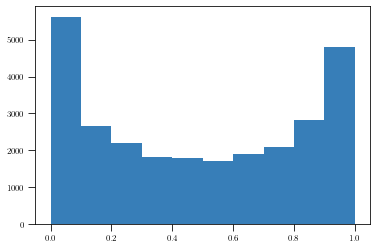

In [22]:
ble = full_truth['blendedness'].numpy().reshape(-1)
ble = ble[ble!=0]
plt.hist(ble)
